In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import omegaconf
import hydra
from lightning import Callback, LightningDataModule, LightningModule, Trainer
from omegaconf import DictConfig
from sklearn.preprocessing import StandardScaler
from fgvc.data.plant_traits_data import *

In [3]:
#all columns must be identical to be consider the same species
trait_columns = ['X4_mean', 'X11_mean', 'X18_mean', 'X50_mean', 'X26_mean', 'X3112_mean']
aux_columns = list(
            map(lambda x: x.replace("mean", "sd"), trait_columns)
        )

In [4]:
df_train = pd.read_csv('/home/ubuntu/FGVC11/data/PlantTrait/train.csv')
df_train['path'] = '/home/ubuntu/FGVC11/data/PlantTrait/train_images/' + df_train['id'].astype(str) + '.jpeg'

df_test = pd.read_csv('/home/ubuntu/FGVC11/data/PlantTrait/test.csv')
df_test['path'] = '/home/ubuntu/FGVC11/data/PlantTrait/test_images/' + df_test['id'].astype(str) + '.jpeg'

In [5]:
metadata_cols = df_train.drop(
                columns=["id", "path"] + trait_columns + aux_columns
            ).columns

### Cleaning DataFrames

In [6]:
for col in trait_columns:
    upper_quantile = df_train[col].quantile(0.98)  
    df_train = df_train[(df_train[col] < upper_quantile)]
    df_train = df_train[(df_train[col] > 0)]  

### Train/Val/Test Splits

In [7]:
# add species column
df_train['species'] = df_train.groupby(trait_columns).ngroup()
df_train['species'] = df_train['species'].astype(str)
species_counts = df_train['species'].nunique()

print (f"{species_counts} unique species found in {len(df_train)} records")

17396 unique species found in 49009 records


In [16]:
df_train['species'].nunique()

17396

In [43]:
# add a split column and do train_testsplit based on species column
df_train['split'] = 'train'
# create a dictionary to store the indices of each species
species_indices = {}

# iterate over each species and select 20% of its indices for validation
for species in tqdm(df_train['species'].unique()):
    species_indices[species] = np.random.choice(df_train[df_train['species'] == species].index, 
                                                size=int(len(df_train[df_train['species'] == species]) * 0.3), 
                                                replace=False)

# update the split column for the selected validation indices
df_train.loc[np.concatenate(list(species_indices.values())), 'split'] = 'val'


  0%|          | 0/17396 [00:00<?, ?it/s]

In [44]:
df_train.columns

Index(['id', 'WORLDCLIM_BIO1_annual_mean_temperature',
       'WORLDCLIM_BIO12_annual_precipitation',
       'WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month',
       'WORLDCLIM_BIO15_precipitation_seasonality',
       'WORLDCLIM_BIO4_temperature_seasonality',
       'WORLDCLIM_BIO7_temperature_annual_range',
       'SOIL_bdod_0.5cm_mean_0.01_deg', 'SOIL_bdod_100.200cm_mean_0.01_deg',
       'SOIL_bdod_15.30cm_mean_0.01_deg',
       ...
       'X3112_mean', 'X4_sd', 'X11_sd', 'X18_sd', 'X26_sd', 'X50_sd',
       'X3112_sd', 'path', 'species', 'split'],
      dtype='object', length=179)

In [45]:
df_train['split'].value_counts()

train    43037
val       5972
Name: split, dtype: int64

In [46]:
df_test["split"] = "test"
df_full = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)

In [47]:
# fill NA in metadata columns
df_full.fillna(0, inplace=True)

### Normalize Metadata Columns

In [49]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

In [50]:
df_full[metadata_cols] = scale.fit_transform(df_full[metadata_cols])

In [53]:
df_full.to_csv('/home/ubuntu/FGVC11/data/PlantTrait/df_processed.csv', index=False)

### Label Encoder

In [82]:
from fgvc.models.plant_traits_model import LabelEncoder

In [83]:
le = LabelEncoder()

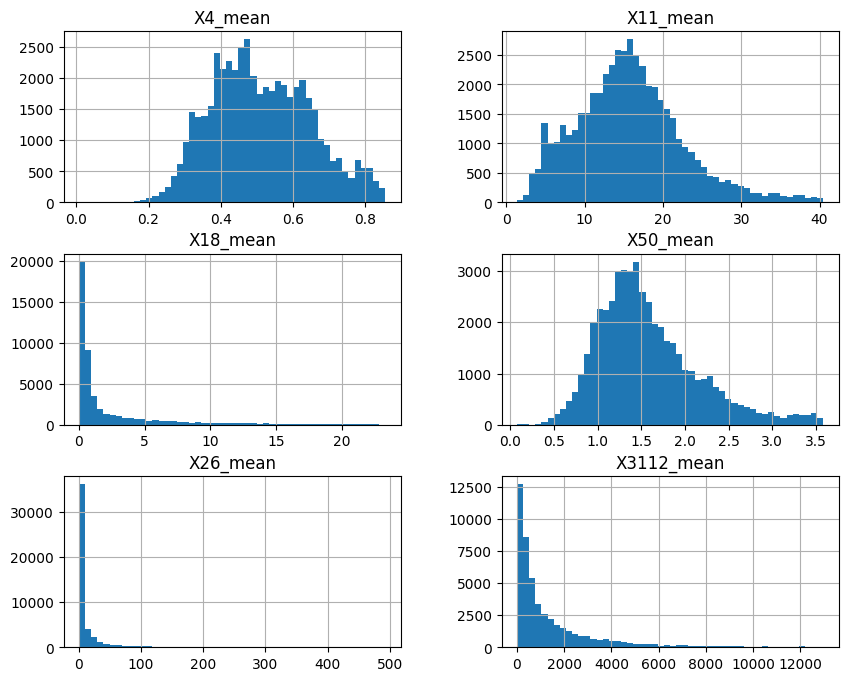

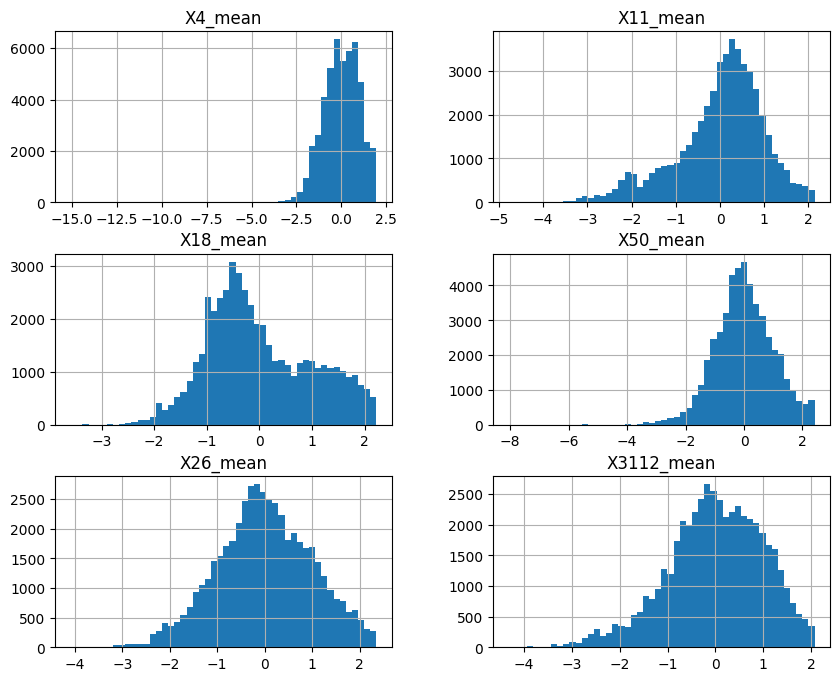

In [84]:
df_train[trait_columns].hist(bins=50, figsize=(10, 8))
plt.show()
X = torch.Tensor(df_train[trait_columns].values)
t = le.transform(X)
t = pd.DataFrame(t, columns=trait_columns)
t.hist(bins=50, figsize=(10, 8))
plt.show()

In [77]:
import pickle
with open('/home/ubuntu/FGVC11/data/PlantTrait/label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

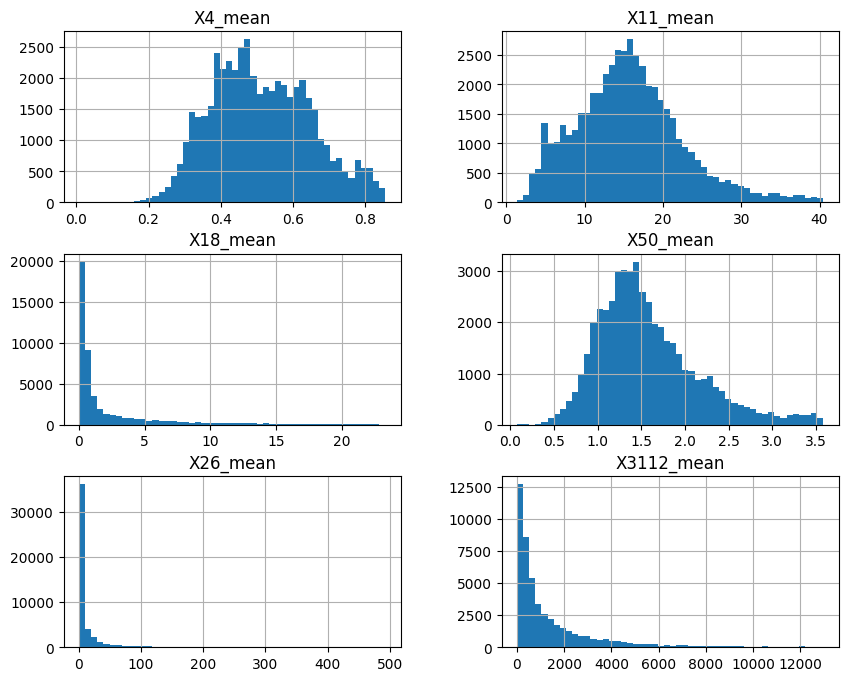

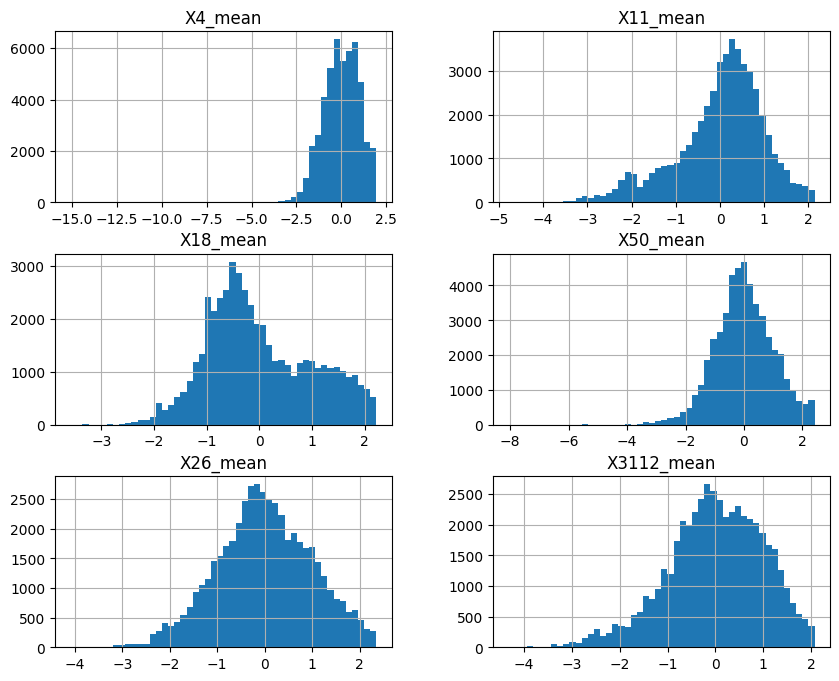

In [78]:
# test the encoder
le = pickle.load(open('/home/ubuntu/FGVC11/data/PlantTrait/label_encoder.pkl', 'rb'))
df_train[trait_columns].hist(bins=50, figsize=(10, 8))
plt.show()
t = le.transform(torch.Tensor(df_train[trait_columns].values))
t = pd.DataFrame(t, columns=trait_columns)
t.hist(bins=50, figsize=(10, 8))
plt.show()